<a href="https://colab.research.google.com/github/waltechel/KaggleStudy20220103/blob/master/chapter04/stock_samsung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import
- 해당 라이브러리는 초기화한 다음에 런타임 초기화하면 안된다

In [1]:
!pip install -U finance-datareader

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
import FinanceDataReader as fdr

# Load Dataset

- 이렇게 데이터를 쓸 수 있어요

```python
format = '%Y-%m-%d'
df_KOSPI = fdr.StockListing('KOSPI') # 코스피
df_KOSDAQ = fdr.StockListing('KOSDAQ') # 코스닥
df_KOSPI = pd.concat([df_KOSPI, df_KOSDAQ])
total_dataframe = pd.DataFrame()
```

- 이렇게 하면 데이터를 가져올 수 있어요.

In [3]:
# 005930 삼성전자
# BTC/KRW 비트코인
# ETH/KRW 이더리움
# XRP/KRW 리플
# BCH/KRW 비트코인 캐시
# EOS/KRW 이오스
# LTC/KRW 라이트 코인
# XLM/KRW 스텔라
df = fdr.DataReader('005930', '2016')

In [4]:
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-01-04,25200,25200,24100,24100,306939,-0.043651
2016-01-05,24040,24360,23720,24160,216002,0.002490
2016-01-06,24160,24160,23360,23500,366752,-0.027318
2016-01-07,23320,23660,23020,23260,282388,-0.010213
2016-01-08,23260,23720,23260,23420,257763,0.006879


# Compute Mid Price

In [5]:
high_prices = df['High'].values
low_prices = df['Low'].values
mid_prices = (high_prices + low_prices) / 2

# Create Windows

In [6]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

# Normalize Data

- 이런 식으로 하면 시계열 분석이 맞는 건가?
  - 이전 9개의 데이터를 학습하고 맨 마지막 1개의 데이터를 맞추는 것으로 생각되는데

In [7]:
normalized_data = []
for window in result:
    if float(window[0]) == 0:
        continue
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1302, 50, 1), (145, 50, 1))

In [10]:
row

1302

# Build a Model

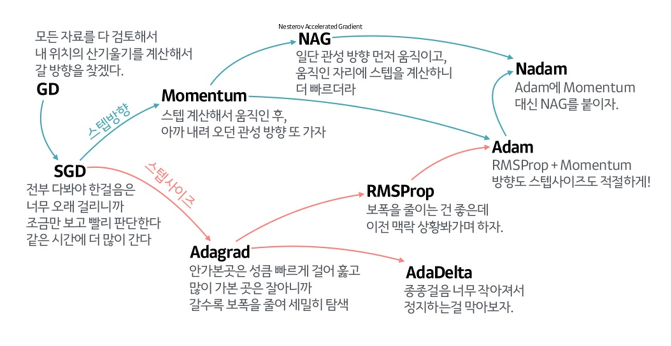

In [ ]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 64)                29440     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
130/130 [==============================] - 9s 43ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 2/20
130/130 [==============================] - 5s 37ms/step - loss: 0.0039 - val_loss: 6.1253e-04
Epoch 3/20
130/130 [==============================] - 5s 38ms/step - loss: 0.0036 - val_loss: 5.0815e-04
Epoch 4/20
 53/130 [===========>..................] - ETA: 2s - loss: 0.0054

# Prediction

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

# 전에 공부했었던 loss function 중 Binary Cross Entropy에 대한 내용
- 이진 분류를 할 때는 Binary Cross Entropy + Adam 같은 loss function과 optimizer 간 조합 공식이 존재하는 것 같다(?)
  - 물론 optimizer를 SGD(확률적 경사하강법), Adam(아담), RMSProp 등등 다양하게 넣을 수도 있다
  ```python
  # 우리가 아까 본 내용
  model.compile(loss='mse', optimizer='rmsprop')
  ```

## Binary Cross Entropy
- loss function의 일종
  - loss function : 모델이 얼마나 잘 예측해내는지를 평가하는 척도
  - 예 : mse, rmse, lmse, bce(Binary Cross Entropy), ce

- Binary Cross Entropy    
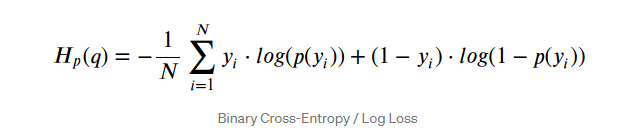
  - p(y)는 y라고 판단할 확률, y는 실제 label(0, 1)

- 엔트로피 지수 공식
  - q(y)는 전체에서 y의 비율  
  - 이건 실젯값을 알고 있음을 전제로 한다.  
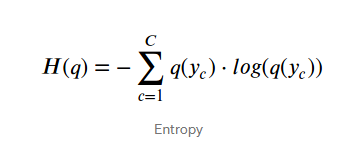
- 크로스엔트로피
  - 실제값을 우리는 모르기 때문에 크로스엔트로피를 적용합니다
  - q(y)는 전체 안의 비율, p(y) 는 y라고 판단할 확률    
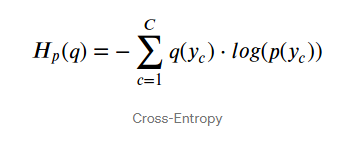

- 콜백-라이블러 발산(Kullback-Leibler Divergence)
  - 크로스엔트로피에서 엔트로피 값을 뺀 것으로, 이 값이 작을수록 엔트로피와 크로스엔트로피는 유사합니다.
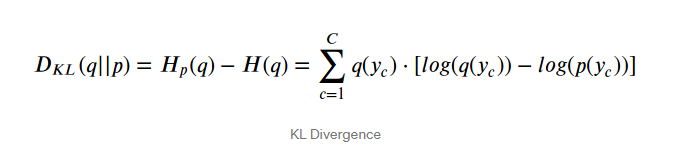

- q(y) 실제 비중과, Hp(q) 예측한 비중    
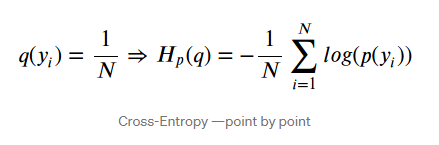

- 우리는 이진 분류를 하기로 했으니 다음과 같이 표현할 수 있습니다.    
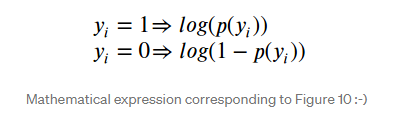

- 아까의 Hp(q) 공식을 다음과 같이 Neg, Pos 두 가지로 나누고(0, 1)
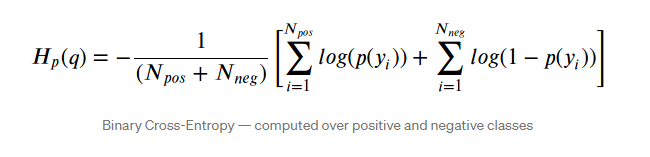

- 정리하면 바이너리 크로스 엔트로피 식을 구할 수 있습니다.    
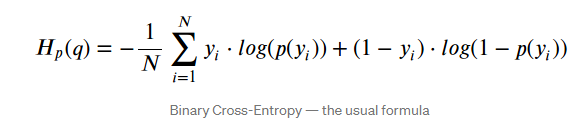



- 출처    
  https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a